In [2]:
import json

tweets_data = []
tweets_file = open('geotagged_tweets_20160812-0912.jsons', "r")
print(tweets_file)

counter = 0
for line in tweets_file:
    counter = counter + 1
    if counter > 30000:
        break
    try:
        tweet = json.loads(line)
        tweets_data.append(tweet)
    except:
        continue

<_io.TextIOWrapper name='geotagged_tweets_20160812-0912.jsons' mode='r' encoding='cp1252'>


In [1]:
import os
import json
import numpy as np
import pandas as pd
import nltk
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import rgb2hex
from descartes import PolygonPatch
from shapely.geometry import Polygon, MultiPolygon
import plotly.offline as py#visualization
import plotly.graph_objs as go#visualization
import plotly.tools as tls#visualization
import plotly.figure_factory as ff#visualization


In [3]:
from pandas.io.json import json_normalize
# Thank gawd for this package - all json fields straight into columns in a dataframe, no bullshit
tweets_df = json_normalize(tweets_data)

tweets_df.head()

,contributors,coordinates,coordinates.coordinates,coordinates.type,created_at,entities.hashtags,entities.media,entities.symbols,entities.urls,entities.user_mentions,...,user.profile_sidebar_fill_color,user.profile_text_color,user.profile_use_background_image,user.protected,user.screen_name,user.statuses_count,user.time_zone,user.url,user.utc_offset,user.verified
0,None,NaN,NaN,NaN,Fri Aug 12 10:04:00 +0000 2016,[],"[{'id': 764039718237409281, 'id_str': '7640397...",[],[],"[{'screen_name': 'theblaze', 'name': 'TheBlaze...",...,EFEFEF,333333,True,False,DUPUY77,17620,None,http://ggm-dupuy.com,NaN,False
1,None,NaN,NaN,NaN,Fri Aug 12 10:04:02 +0000 2016,"[{'text': 'NOJUSTICE', 'indices': [62, 72]}, {...",NaN,[],"[{'url': 'https://t.co/5GMNZq40V3', 'expanded_...","[{'screen_name': 'BarackObama', 'name': 'Barac...",...,000000,000000,False,False,redoctapus,5046,Eastern Time (US & Canada),None,-14400.0,False
2,None,NaN,NaN,NaN,Fri Aug 12 10:04:10 +0000 2016,[],"[{'id': 764039762973896704, 'id_str': '7640397...",[],[],"[{'screen_name': 'theblaze', 'name': 'TheBlaze...",...,EFEFEF,333333,True,False,DUPUY77,17621,None,http://ggm-dupuy.com,NaN,False
3,None,NaN,NaN,NaN,Fri Aug 12 10:04:21 +0000 2016,[],NaN,[],[],"[{'screen_name': 'HillaryClinton', 'name': 'Hi...",...,99CC33,3E4415,True,False,jjorgi30,2231,Melbourne,None,36000.0,False
4,None,NaN,NaN,NaN,Fri Aug 12 10:04:30 +0000 2016,"[{'text': 'CNN', 'indices': [0, 4]}, {'text': ...",NaN,[],[],[],...,F3F3F3,333333,True,False,bspence5,92605,None,None,NaN,False


In [115]:
cols = []

for col in tweets_df.columns:
    if col in ('user.region','created_at', 'place.country','place.name','lang','text','user.name','user.location'):
        cols.append(col)

neat_df = tweets_df.loc[:, cols]
neat_df.head()

,created_at,lang,place.country,place.name,text,user.location,user.name
0,Fri Aug 12 10:04:00 +0000 2016,und,United States,Frontenac,@theblaze @realDonaldTrump https://t.co/TY9DlZ...,Miami,GIL DUPUY
1,Fri Aug 12 10:04:02 +0000 2016,en,United States,Baton Rouge,@BarackObama \n@FBI\n@LORETTALYNCH \nALL IN CO...,"Ogletown, DE",Red Octopus
2,Fri Aug 12 10:04:10 +0000 2016,und,United States,Frontenac,@theblaze @realDonaldTrump https://t.co/n050DB...,Miami,GIL DUPUY
3,Fri Aug 12 10:04:21 +0000 2016,en,Australia,Melbourne,@HillaryClinton he will do in one year all the...,Australia,JanJorgenson
4,Fri Aug 12 10:04:30 +0000 2016,en,United States,Baltimore,#CNN #newday clear #Trump deliberately throwin...,None,Beverly Spence


In [116]:
# create an empty list for the text that has been "cleaned"
list_clean_text = []

for i in neat_df["text"]:
    # this removes the hyperlink
    result = re.sub(r"http\S+", "", i)
    # this removes the people the text was directed to e.g. @HillaryClinton or @CNN
    result2 = re.sub(r"\B@\S+.", "", result)
    result3 = re.sub(r"\d+.", "", result2)
    list_clean_text.append(result3)

# make a new column with the clean text
neat_df["clean_text"] = list_clean_text
neat_df

,created_at,lang,place.country,place.name,text,user.location,user.name,clean_text
0,Fri Aug 12 10:04:00 +0000 2016,und,United States,Frontenac,@theblaze @realDonaldTrump https://t.co/TY9DlZ...,Miami,GIL DUPUY,
1,Fri Aug 12 10:04:02 +0000 2016,en,United States,Baton Rouge,@BarackObama \n@FBI\n@LORETTALYNCH \nALL IN CO...,"Ogletown, DE",Red Octopus,\n\n\nALL IN COLLUSION TOGETHER \n\n#NOJUSTICE...
2,Fri Aug 12 10:04:10 +0000 2016,und,United States,Frontenac,@theblaze @realDonaldTrump https://t.co/n050DB...,Miami,GIL DUPUY,
3,Fri Aug 12 10:04:21 +0000 2016,en,Australia,Melbourne,@HillaryClinton he will do in one year all the...,Australia,JanJorgenson,he will do in one year all the things you shou...
4,Fri Aug 12 10:04:30 +0000 2016,en,United States,Baltimore,#CNN #newday clear #Trump deliberately throwin...,None,Beverly Spence,#CNN #newday clear #Trump deliberately throwin...
5,Fri Aug 12 10:04:46 +0000 2016,en,United States,Palm Springs,"@realDonaldTrump, you wouldn't recognize a lie...","Palm Springs, CA","Asa DeMatteo, Ph.D.",you wouldn't recognize a lie if it came from y...
6,Fri Aug 12 10:04:47 +0000 2016,und,United Kingdom,Hammersmith,#Trump2016 #TrumpPence16 #MakeAmericaGreatAgai...,Stuck in the middle with you,Hank Moody,#Trump#TrumpPence#MakeAmericaGreatAgain
7,Fri Aug 12 10:04:48 +0000 2016,en,United States,Secaucus,"""Kid, you know, suing someone? Thats the most ...","Secaucus, NJ",Rafael Alejandro,"""Kid, you know, suing someone? Thats the most ..."
8,Fri Aug 12 10:04:48 +0000 2016,en,United States,Irving,@HillaryClinton you ARE the co-founder of ISIS...,"Irving, TX",tom b,"you ARE the co-founder of ISIS, you crooked, e..."
9,Fri Aug 12 10:04:49 +0000 2016,en,Australia,Brisbane,@Geraldanthro @NeilTurner_ @realDonaldTrump wa...,Queensland OZ,michael halliday777,want to do a comparison try maimed Vets pre &a...


In [118]:
#Lexicon Normalization
#performing stemming and Lemmatization
from nltk.corpus import stopwords 
from nltk.stem.wordnet import WordNetLemmatizer
import string

# Create a set of stopwords
stop = set(stopwords.words('english'))
stop.update(set(["n", "u", "im"]))

# Create a set of punctuation words 
exclude = set(string.punctuation) 

# This is the function makeing the lemmatization
lemma = WordNetLemmatizer()

# In this function we perform the entire cleaning
def clean(doc):
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    return normalized

# This is the clean corpus.
doc_clean = [clean(doc) for doc in list_clean_text] 

In [119]:
from nltk.tokenize import RegexpTokenizer
import html.parser as HTMLParser# In Python 3.4+ import html 
import nltk

# Tokenize each clean text
tokenized_tweets = []
tokenizer = RegexpTokenizer(r'\w+')
for i in doc_clean:
    tokens = tokenizer.tokenize(i)
    tokenized_tweets.append(tokens)

neat_df["tokens"] = tokenized_tweets
# flatten the list of lists to combine all words in one list
flattened_list_of_tokens = [y for x in tokenized_tweets for y in x]
neat_df

,created_at,lang,place.country,place.name,text,user.location,user.name,clean_text,tokens
0,Fri Aug 12 10:04:00 +0000 2016,und,United States,Frontenac,@theblaze @realDonaldTrump https://t.co/TY9DlZ...,Miami,GIL DUPUY,,[]
1,Fri Aug 12 10:04:02 +0000 2016,en,United States,Baton Rouge,@BarackObama \n@FBI\n@LORETTALYNCH \nALL IN CO...,"Ogletown, DE",Red Octopus,\n\n\nALL IN COLLUSION TOGETHER \n\n#NOJUSTICE...,"[collusion, together, nojustice, trumppence]"
2,Fri Aug 12 10:04:10 +0000 2016,und,United States,Frontenac,@theblaze @realDonaldTrump https://t.co/n050DB...,Miami,GIL DUPUY,,[]
3,Fri Aug 12 10:04:21 +0000 2016,en,Australia,Melbourne,@HillaryClinton he will do in one year all the...,Australia,JanJorgenson,he will do in one year all the things you shou...,"[one, year, thing, done, eight]"
4,Fri Aug 12 10:04:30 +0000 2016,en,United States,Baltimore,#CNN #newday clear #Trump deliberately throwin...,None,Beverly Spence,#CNN #newday clear #Trump deliberately throwin...,"[cnn, newday, clear, trump, deliberately, thro..."
5,Fri Aug 12 10:04:46 +0000 2016,en,United States,Palm Springs,"@realDonaldTrump, you wouldn't recognize a lie...","Palm Springs, CA","Asa DeMatteo, Ph.D.",you wouldn't recognize a lie if it came from y...,"[recognize, lie, came, mouth, continually, nev..."
6,Fri Aug 12 10:04:47 +0000 2016,und,United Kingdom,Hammersmith,#Trump2016 #TrumpPence16 #MakeAmericaGreatAgai...,Stuck in the middle with you,Hank Moody,#Trump#TrumpPence#MakeAmericaGreatAgain,[trumptrumppencemakeamericagreatagain]
7,Fri Aug 12 10:04:48 +0000 2016,en,United States,Secaucus,"""Kid, you know, suing someone? Thats the most ...","Secaucus, NJ",Rafael Alejandro,"""Kid, you know, suing someone? Thats the most ...","[kid, know, suing, someone, thats, beautiful, ..."
8,Fri Aug 12 10:04:48 +0000 2016,en,United States,Irving,@HillaryClinton you ARE the co-founder of ISIS...,"Irving, TX",tom b,"you ARE the co-founder of ISIS, you crooked, e...","[cofounder, isi, crooked, evil, lying, witch, ..."
9,Fri Aug 12 10:04:49 +0000 2016,en,Australia,Brisbane,@Geraldanthro @NeilTurner_ @realDonaldTrump wa...,Queensland OZ,michael halliday777,want to do a comparison try maimed Vets pre &a...,"[want, comparison, try, maimed, vet, pre, amp,..."


In [38]:
pip install textblob

Note: you may need to restart the kernel to use updated packages.


In [147]:
from textblob import TextBlob as tb

neat_df['sentiment'] = neat_df['tokens'].apply(lambda x: tb(" ".join(x)).sentiment[0] )
#tweets[['text','calc_sentiment']]

neat_df.head()

,created_at,lang,place.country,place.name,text,user.location,user.name,clean_text,tokens,sentiment,state,hashtags
0,Fri Aug 12 10:04:00 +0000 2016,und,United States,Frontenac,@theblaze @realDonaldTrump https://t.co/TY9DlZ...,Miami,GIL DUPUY,,[],0.0,NaN,[]
1,Fri Aug 12 10:04:02 +0000 2016,en,United States,Baton Rouge,@BarackObama \n@FBI\n@LORETTALYNCH \nALL IN CO...,"Ogletown, DE",Red Octopus,\n\n\nALL IN COLLUSION TOGETHER \n\n#NOJUSTICE...,"[collusion, together, nojustice, trumppence]",0.0,DE,"[#NOJUSTICE, #TrumpPence]"
2,Fri Aug 12 10:04:10 +0000 2016,und,United States,Frontenac,@theblaze @realDonaldTrump https://t.co/n050DB...,Miami,GIL DUPUY,,[],0.0,NaN,[]
3,Fri Aug 12 10:04:21 +0000 2016,en,Australia,Melbourne,@HillaryClinton he will do in one year all the...,Australia,JanJorgenson,he will do in one year all the things you shou...,"[one, year, thing, done, eight]",0.0,NaN,[]
4,Fri Aug 12 10:04:30 +0000 2016,en,United States,Baltimore,#CNN #newday clear #Trump deliberately throwin...,,Beverly Spence,#CNN #newday clear #Trump deliberately throwin...,"[cnn, newday, clear, trump, deliberately, thro...",0.1,NaN,"[#CNN, #newday, #Trump, #ISIS]"


In [148]:
import re
def find_hashtags(tweet):
    '''This function will extract hashtags'''
    return re.findall('(#[A-Za-z]+[A-Za-z0-9-_]+)', tweet)

neat_df['hashtags'] = neat_df.text.apply(find_hashtags)
neat_df.head()

,created_at,lang,place.country,place.name,text,user.location,user.name,clean_text,tokens,sentiment,state,hashtags
0,Fri Aug 12 10:04:00 +0000 2016,und,United States,Frontenac,@theblaze @realDonaldTrump https://t.co/TY9DlZ...,Miami,GIL DUPUY,,[],0.0,NaN,[]
1,Fri Aug 12 10:04:02 +0000 2016,en,United States,Baton Rouge,@BarackObama \n@FBI\n@LORETTALYNCH \nALL IN CO...,"Ogletown, DE",Red Octopus,\n\n\nALL IN COLLUSION TOGETHER \n\n#NOJUSTICE...,"[collusion, together, nojustice, trumppence]",0.0,DE,"[#NOJUSTICE, #TrumpPence]"
2,Fri Aug 12 10:04:10 +0000 2016,und,United States,Frontenac,@theblaze @realDonaldTrump https://t.co/n050DB...,Miami,GIL DUPUY,,[],0.0,NaN,[]
3,Fri Aug 12 10:04:21 +0000 2016,en,Australia,Melbourne,@HillaryClinton he will do in one year all the...,Australia,JanJorgenson,he will do in one year all the things you shou...,"[one, year, thing, done, eight]",0.0,NaN,[]
4,Fri Aug 12 10:04:30 +0000 2016,en,United States,Baltimore,#CNN #newday clear #Trump deliberately throwin...,,Beverly Spence,#CNN #newday clear #Trump deliberately throwin...,"[cnn, newday, clear, trump, deliberately, thro...",0.1,NaN,"[#CNN, #newday, #Trump, #ISIS]"


In [149]:
STATES = ['Alabama', 'AL', 'Alaska', 'AK', 'Arizona', 'AZ', 'Arkansas', 'AR', 'California', 'CA', 'Colorado', 'CO', 'Connecticut', 'CT', \
'Delaware', 'DE', 'Florida', 'FL', 'Georgia', 'GA', 'Hawaii', 'HI', 'Idaho', 'ID', 'Illinois', 'IL', 'Indiana', 'IN', 'Iowa', 'IA', \
'Kansas', 'KS', 'Kentucky', 'KY', 'Louisiana', 'LA', 'Maine', 'ME', 'Maryland', 'MD', 'Massachusetts', 'MA', 'Michigan', 'MI', \
'Minnesota', 'MN', 'Mississippi', 'MS', 'Missouri', 'MO', 'Montana', 'MT', 'Nebraska', 'NE', 'Nevada', 'NV', 'New Hampshire', 'NH', \
'New Jersey', 'NJ', 'New Mexico', 'NM', 'New York', 'NY', 'North Carolina', 'NC', 'North Dakota', 'ND', 'Ohio', 'OH', 'Oklahoma', 'OK', \
'Oregon', 'OR', 'Pennsylvania', 'PA', 'Rhode Island', 'RI', 'South Carolina', 'SC', 'South Dakota', 'SD', 'Tennessee', 'TN', \
'Texas', 'TX', 'Utah', 'UT', 'Vermont', 'VT', 'Virginia', 'VA', 'Washington', 'WA', 'West Virginia', 'WV', 'Wisconsin', 'WI', 'Wyoming', 'WY']


In [150]:
import itertools
STATE_DICT = dict(itertools.zip_longest(*[iter(STATES)] * 2, fillvalue=""))
INV_STATE_DICT = dict((v,k) for k,v in STATE_DICT.items())
INV_STATE_DICT

{'AL': 'Alabama',
 'AK': 'Alaska',
 'AZ': 'Arizona',
 'AR': 'Arkansas',
 'CA': 'California',
 'CO': 'Colorado',
 'CT': 'Connecticut',
 'DE': 'Delaware',
 'FL': 'Florida',
 'GA': 'Georgia',
 'HI': 'Hawaii',
 'ID': 'Idaho',
 'IL': 'Illinois',
 'IN': 'Indiana',
 'IA': 'Iowa',
 'KS': 'Kansas',
 'KY': 'Kentucky',
 'LA': 'Louisiana',
 'ME': 'Maine',
 'MD': 'Maryland',
 'MA': 'Massachusetts',
 'MI': 'Michigan',
 'MN': 'Minnesota',
 'MS': 'Mississippi',
 'MO': 'Missouri',
 'MT': 'Montana',
 'NE': 'Nebraska',
 'NV': 'Nevada',
 'NH': 'New Hampshire',
 'NJ': 'New Jersey',
 'NM': 'New Mexico',
 'NY': 'New York',
 'NC': 'North Carolina',
 'ND': 'North Dakota',
 'OH': 'Ohio',
 'OK': 'Oklahoma',
 'OR': 'Oregon',
 'PA': 'Pennsylvania',
 'RI': 'Rhode Island',
 'SC': 'South Carolina',
 'SD': 'South Dakota',
 'TN': 'Tennessee',
 'TX': 'Texas',
 'UT': 'Utah',
 'VT': 'Vermont',
 'VA': 'Virginia',
 'WA': 'Washington',
 'WV': 'West Virginia',
 'WI': 'Wisconsin',
 'WY': 'Wyoming'}

In [151]:
is_in_US=[]
geo = neat_df[['user.location']]
neat_df = neat_df.fillna(" ")
for x in neat_df['user.location']:
    check = False
    for s in STATES:
        if s in x:
            is_in_US.append(STATE_DICT[s] if s in STATE_DICT else s)
            check = True
            break
    if not check:
        is_in_US.append(np.nan)

neat_df['state'] = is_in_US
neat_df

,created_at,lang,place.country,place.name,text,user.location,user.name,clean_text,tokens,sentiment,state,hashtags
0,Fri Aug 12 10:04:00 +0000 2016,und,United States,Frontenac,@theblaze @realDonaldTrump https://t.co/TY9DlZ...,Miami,GIL DUPUY,,[],0.000000,NaN,[]
1,Fri Aug 12 10:04:02 +0000 2016,en,United States,Baton Rouge,@BarackObama \n@FBI\n@LORETTALYNCH \nALL IN CO...,"Ogletown, DE",Red Octopus,\n\n\nALL IN COLLUSION TOGETHER \n\n#NOJUSTICE...,"[collusion, together, nojustice, trumppence]",0.000000,DE,"[#NOJUSTICE, #TrumpPence]"
2,Fri Aug 12 10:04:10 +0000 2016,und,United States,Frontenac,@theblaze @realDonaldTrump https://t.co/n050DB...,Miami,GIL DUPUY,,[],0.000000,NaN,[]
3,Fri Aug 12 10:04:21 +0000 2016,en,Australia,Melbourne,@HillaryClinton he will do in one year all the...,Australia,JanJorgenson,he will do in one year all the things you shou...,"[one, year, thing, done, eight]",0.000000,NaN,[]
4,Fri Aug 12 10:04:30 +0000 2016,en,United States,Baltimore,#CNN #newday clear #Trump deliberately throwin...,,Beverly Spence,#CNN #newday clear #Trump deliberately throwin...,"[cnn, newday, clear, trump, deliberately, thro...",0.100000,NaN,"[#CNN, #newday, #Trump, #ISIS]"
5,Fri Aug 12 10:04:46 +0000 2016,en,United States,Palm Springs,"@realDonaldTrump, you wouldn't recognize a lie...","Palm Springs, CA","Asa DeMatteo, Ph.D.",you wouldn't recognize a lie if it came from y...,"[recognize, lie, came, mouth, continually, nev...",0.000000,CA,[#NeverTrump]
6,Fri Aug 12 10:04:47 +0000 2016,und,United Kingdom,Hammersmith,#Trump2016 #TrumpPence16 #MakeAmericaGreatAgai...,Stuck in the middle with you,Hank Moody,#Trump#TrumpPence#MakeAmericaGreatAgain,[trumptrumppencemakeamericagreatagain],0.000000,NaN,"[#Trump2016, #TrumpPence16, #MakeAmericaGreatA..."
7,Fri Aug 12 10:04:48 +0000 2016,en,United States,Secaucus,"""Kid, you know, suing someone? Thats the most ...","Secaucus, NJ",Rafael Alejandro,"""Kid, you know, suing someone? Thats the most ...","[kid, know, suing, someone, thats, beautiful, ...",0.283333,NJ,[]
8,Fri Aug 12 10:04:48 +0000 2016,en,United States,Irving,@HillaryClinton you ARE the co-founder of ISIS...,"Irving, TX",tom b,"you ARE the co-founder of ISIS, you crooked, e...","[cofounder, isi, crooked, evil, lying, witch, ...",-0.287879,TX,[]
9,Fri Aug 12 10:04:49 +0000 2016,en,Australia,Brisbane,@Geraldanthro @NeilTurner_ @realDonaldTrump wa...,Queensland OZ,michael halliday777,want to do a comparison try maimed Vets pre &a...,"[want, comparison, try, maimed, vet, pre, amp,...",0.000000,NaN,[]


In [196]:
states_df['#nevertrump'] = states_df['text'].str.contains("#nevertrump", case = False)
states_df['#neverhillary'] = states_df['text'].str.contains("#neverhillary", case = False)
states_df['#maga'] = states_df['text'].str.contains("#maga", case = False)
states_df

,created_at,lang,place.country,place.name,text,user.location,user.name,clean_text,tokens,sentiment,state,hashtags,nevertrump,#nevertrump,#neverhillary,#maga
0,Fri Aug 12 10:04:02 +0000 2016,en,United States,Baton Rouge,@BarackObama \n@FBI\n@LORETTALYNCH \nALL IN CO...,"Ogletown, DE",Red Octopus,\n\n\nALL IN COLLUSION TOGETHER \n\n#NOJUSTICE...,"[collusion, together, nojustice, trumppence]",0.000000,DE,"[#NOJUSTICE, #TrumpPence]",NaN,False,False,False
1,Fri Aug 12 10:04:46 +0000 2016,en,United States,Palm Springs,"@realDonaldTrump, you wouldn't recognize a lie...","Palm Springs, CA","Asa DeMatteo, Ph.D.",you wouldn't recognize a lie if it came from y...,"[recognize, lie, came, mouth, continually, nev...",0.000000,CA,[#NeverTrump],NaN,True,False,False
2,Fri Aug 12 10:04:48 +0000 2016,en,United States,Secaucus,"""Kid, you know, suing someone? Thats the most ...","Secaucus, NJ",Rafael Alejandro,"""Kid, you know, suing someone? Thats the most ...","[kid, know, suing, someone, thats, beautiful, ...",0.283333,NJ,[],NaN,False,False,False
3,Fri Aug 12 10:04:48 +0000 2016,en,United States,Irving,@HillaryClinton you ARE the co-founder of ISIS...,"Irving, TX",tom b,"you ARE the co-founder of ISIS, you crooked, e...","[cofounder, isi, crooked, evil, lying, witch, ...",-0.287879,TX,[],NaN,False,False,False
4,Fri Aug 12 10:04:53 +0000 2016,en,United States,Chesapeake Beach,@mike4193496 @realDonaldTrump I TOTALLY CONCUR...,"Maryland, USA",Kim Wasson,I TOTALLY CONCUR!! This Election is just CRA C...,"[totally, concur, election, cra, cra, corrupti...",0.000000,MD,[],NaN,False,False,False
5,Fri Aug 12 10:05:04 +0000 2016,en,United States,Middletown,Can't stand @HillaryClinton or @realDonaldTrum...,"Louisville, KY/Palm Coast, FL",David Mills,Can't stand or a look. They can win...don't se...,"[cant, stand, look, windont, settle, orteamgov...",0.000000,FL,"[#TeamGov, #YouIn]",NaN,False,False,False
6,Fri Aug 12 10:05:18 +0000 2016,en,United States,Davenport,@CribBoss @WesSmith123 @realDonaldTrump why is...,Iowa,robert troxel,why isn't his rape allegations getting more at...,"[rape, allegation, getting, attention, cause, ...",0.000000,IA,[],NaN,False,False,False
7,Fri Aug 12 10:06:05 +0000 2016,en,United States,Irving,@HillaryClinton ISIS co-founder Hillary Clinto...,"Irving, TX",tom b,ISIS co-founder Hillary Clinton. Obama also he...,"[isi, cofounder, hillary, clinton, obama, also...",0.000000,TX,[],NaN,False,False,False
8,Fri Aug 12 10:06:49 +0000 2016,en,United States,Irving,@HFA @HillaryClinton wake up Dems Hillary is c...,"Irving, TX",tom b,wake up Dems Hillary is cofounder of Isis,"[wake, dems, hillary, cofounder, isi]",0.000000,TX,[],NaN,False,False,False
9,Fri Aug 12 10:08:00 +0000 2016,en,United States,Framingham,2008 there was no #ISIS. It was @BarackObama ...,Virginia,"It's Me, Greg!",there was no #ISIS. It was and policies that ...,"[isi, policy, created, uprising, youarerespons...",0.000000,VA,"[#ISIS, #YouareResponsibleHillary]",NaN,False,False,False


In [ ]:
maga_states_df =states_df.groupby('state')['sentiment'].mean().to_frame().reset_index()

In [136]:
states_df.groupby(['state']).groups.keys()

dict_keys(['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA', 'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY'])

In [206]:
sentiment_states_df = states_df.groupby('state')['#maga'].value_counts()
#sentiment_states_df.columns = ['State', 'Maga mentioned']
sentiment_states_df

SyntaxError: invalid syntax (<ipython-input-206-27a3137fd362>, line 1)

In [142]:
sentiment_states_df['Full State Name'] = sentiment_states_df['State'].apply(lambda x: INV_STATE_DICT[x])
sentiment_states_df['text'] = sentiment_states_df['Full State Name'] + '<br>' + 'Num: ' + sentiment_states_df['Sentiment'].astype(str)
sentiment_states_df

,State,Sentiment,Full State Name,text
0,AK,0.020015,Alaska,Alaska<br>Num: 0.020014880952380958
1,AL,0.017253,Alabama,Alabama<br>Num: 0.01725287569573284
2,AR,-0.009654,Arkansas,Arkansas<br>Num: -0.009653865334012395
3,AZ,0.030657,Arizona,Arizona<br>Num: 0.030657194508000956
4,CA,0.024321,California,California<br>Num: 0.024321456640749195
5,CO,0.006031,Colorado,Colorado<br>Num: 0.006030537378014464
6,CT,-0.030170,Connecticut,Connecticut<br>Num: -0.03016968797960533
7,DE,0.056139,Delaware,Delaware<br>Num: 0.056139045530492905
8,FL,0.041978,Florida,Florida<br>Num: 0.041978198773874646
9,GA,0.041368,Georgia,Georgia<br>Num: 0.04136792557717132


In [145]:
import plotly.graph_objects as go
fig = go.Figure(data=go.Choropleth(locations=sentiment_states_df['State'], z = sentiment_states_df['Sentiment'].astype(float), locationmode = 'USA-states', colorscale = "Reds", text=sentiment_states_df['text'], marker_line_color='white', colorbar_title = "Sentiment score"))
fig.update_layout(geo_scope='usa')
fig.show(renderer="browser")

In [130]:
tweets_by_state = states_df['state'].value_counts()

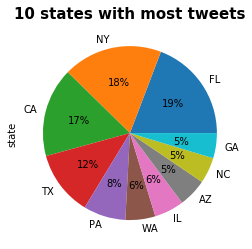

In [131]:
fig, ax = plt.subplots()
ax.set_title('10 states with most tweets', fontsize=15, fontweight='bold')
tweets_by_state[:10].plot(ax=ax, kind='pie', autopct='%1.0f%%')

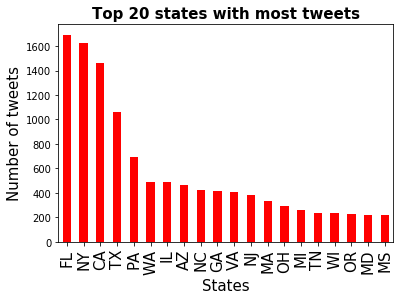

In [132]:
fig, ax = plt.subplots()
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=10)
ax.set_xlabel('States', fontsize=15)
ax.set_ylabel('Number of tweets' , fontsize=15)
ax.set_title('Top 20 states with most tweets', fontsize=15, fontweight='bold')
tweets_by_state[:20].plot(ax=ax, kind='bar', color='red')

In [133]:
geo_dist = tweets_by_state.to_frame().reset_index()
geo_dist.columns = ['State', 'Nr. of tweets']
geo_dist

,State,Nr. of tweets
0,FL,1694
1,NY,1629
2,CA,1463
3,TX,1063
4,PA,693
5,WA,490
6,IL,487
7,AZ,465
8,NC,426
9,GA,411


In [83]:
import math
geo_dist["Log Num"] = geo_dist["Nr. of tweets"].apply(lambda x: math.log(x, 2))

In [84]:
geo_dist

,State,Nr. of tweets,Log Num
0,FL,1694,10.726218
1,NY,1629,10.669771
2,CA,1463,10.514714
3,TX,1063,10.053926
4,PA,693,9.436712
5,WA,490,8.936638
6,IL,487,8.927778
7,AZ,465,8.861087
8,NC,426,8.734710
9,GA,411,8.682995


In [87]:
geo_dist['Full State Name'] = geo_dist['State'].apply(lambda x: INV_STATE_DICT[x])
geo_dist['text'] = geo_dist['Full State Name'] + '<br>' + 'Num: ' + geo_dist['Nr. of tweets'].astype(str)
geo_dist

,State,Nr. of tweets,Log Num,Full State Name,text
0,FL,1694,10.726218,Florida,Florida<br>Num: 1694
1,NY,1629,10.669771,New York,New York<br>Num: 1629
2,CA,1463,10.514714,California,California<br>Num: 1463
3,TX,1063,10.053926,Texas,Texas<br>Num: 1063
4,PA,693,9.436712,Pennsylvania,Pennsylvania<br>Num: 693
5,WA,490,8.936638,Washington,Washington<br>Num: 490
6,IL,487,8.927778,Illinois,Illinois<br>Num: 487
7,AZ,465,8.861087,Arizona,Arizona<br>Num: 465
8,NC,426,8.734710,North Carolina,North Carolina<br>Num: 426
9,GA,411,8.682995,Georgia,Georgia<br>Num: 411


In [104]:
import plotly.graph_objects as go
fig = go.Figure(data=go.Choropleth(locations=geo_dist['State'], z = geo_dist['Log Num'].astype(float), locationmode = 'USA-states', colorscale = "Reds", text=geo_dist['text'], marker_line_color='white', colorbar_title = "Numbers in Log2"))
fig.update_layout(geo_scope='usa')
fig.show(renderer="browser")